In [1]:
import numpy as np
import cvxpy as cvx
from cvxpy import *
import pandas as pd
import matplotlib.pyplot as plt  # the tidy way 
from scipy.misc import comb
%matplotlib inline
#import seaborn as sns # plotting of statistical data
#sns.set()

ImportError: No module named cvxpy

Load the data as a pandas dataframe

In [2]:
prometheus_df = pd.read_csv('treatment1complete.csv')

Select all rows belonging to subject number 6 for round 9

In [3]:
prometheus_df[(prometheus_df['Subject'] == 6) & (prometheus_df['round'] == 19)]

,rowindex,Session,Subject,SubjectID,Timing,eventType,eventIndex,eventClicked,task,columnIndex,...,cluesviewed,miliseconds,seconds,cluemath,cluews,clueboth,clueindex,maxtaskchosen,correct,wrong
38,39,2,6,135264567,706,task,1,Task 1,1.0,1,...,3,13100.0,13.1,1,0,0,14.0,0,NaN,NaN
39,40,2,6,135264567,5676,task,1,Task 3,3.0,2,...,3,13100.0,13.1,0,1,0,3.0,0,NaN,NaN
40,41,2,6,135264567,2199,task,1,Task 3,3.0,2,...,3,13100.0,13.1,0,1,0,10.0,0,NaN,NaN
41,42,2,6,135264567,4519,trial,0,ESFO,NaN,2,...,3,13100.0,13.1,0,0,0,NaN,0,1.0,0.0


In [4]:
succinct_df = prometheus_df[['Subject', 'eventIndex','taskchosen', 'round', 'cluesviewed', 'cluemath','cluews','clueindex']]
succinct_df[(succinct_df['Subject'] == 6) & (succinct_df['round'] == 19)]

,Subject,eventIndex,taskchosen,round,cluesviewed,cluemath,cluews,clueindex
38,6,1,0,19,3,1,0,14.0
39,6,1,0,19,3,0,1,3.0
40,6,1,0,19,3,0,1,10.0
41,6,0,0,19,3,0,0,NaN


In [5]:
#succinct_df[(succinct_df['Subject'] <= 7)]

subject = 8;
succinct_subj = succinct_df[(prometheus_df['Subject'] == subject)]
print('for subject ' + str(subject) + ' max no of rounds = ' + str(max(succinct_subj['round'])))
#succinct_subj


for subject 8 max no of rounds = 49


In [6]:
def ShannonEntropy(rho):
    result = -rho[0]*np.log2(rho[0]) -rho[1]*np.log2(rho[1])
    return result

def absEntropy(rho):
    result = 1-np.max(rho[0],rho[1])
    return result


def uncertaintyFunction(beta,rho):
    result = beta[0]*ShannonEntropy(rho) + beta[1]*absEntropy(rho)
    return result

def bernstein_poly(k,n,p):
    return comb(n,k)* (p**(n-k))*(1-p)**k

def bernstein_poly_second_deriv(k,n,p):
    termOne = k*(k-1)*p**(k-2)*(1-p)**(n-k)
    termTwo = -k*(n-k)*p**(k-1)*(1-p)**(n-k-1)
    termThree = -(n-k)*k*p**(k-1)*(1-p)**(n-k-1)
    termFour = (n-k)*(n-k-1)*p**k*(1-p)**(n-k-2)    
    return comb(n,k)* (termOne+termTwo + termThree+termFour)

# maxOrder = length(w)-1
def plot_bernstein(maxOrder,resolution,w):
    pvals = np.linspace(0,1,resolution)
    Bernvals = np.linspace(0,1,resolution);
    for itr in range(resolution):
        p = pvals[itr]
        Bernvals[itr]=0;
        for k in range(maxOrder+1):
            Bernvals[itr]=Bernvals[itr]+w[k]* bernstein_poly(k,maxOrder,p)
    plt.plot(pvals,Bernvals,'o')
    
def plot_bernstein_secondDeriv(maxOrder,resolution,w):
    pvals = np.linspace(0,1,resolution)
    BernSecondvals = np.linspace(0,1,resolution);
    for itr in range(resolution):
        p = pvals[itr]
        BernSecondvals[itr]=0;
        for k in range(maxOrder+1):
            BernSecondvals[itr]=BernSecondvals[itr]+w[k]* bernstein_poly_second_deriv(k,maxOrder,p)
    plt.plot(pvals,BernSecondvals,'o')
    #print('maximum second derivative: ' + str(np.max(BernSecondvals)))
    print('maximum second derivative: ' + str((BernSecondvals)))

In [7]:
#beta = np.array([2.8,1.3])
beta = np.array([1,0])
rho = np.array([0.5,0.5])
rho
uncertaintyFunction(beta,rho)

1.0

For each subject, for each session, show me the **maximum** number of tasks they completed

** The Basic Mathematics **
The action can be one of four actions
 * $C_A$: continue and get more clues from column A.  This means that **(eventIndex,columnIndex)=(1,1)**
 * $C_B$: continue and get more clues from column B. This means that **(eventIndex,columnIndex)=(1,2)**
 * $S_A$: stop and answer question from column A. This means that **(eventIndex,columnIndex)=(0,1)**
 * $S_B$: stop and answer question from column B. This means that **(eventIndex,columnIndex)=(0,2)**


** The Utility Function **

We model the utility function $U(\rho)=\sum_{k=1}^K \beta_i U_i(\rho)$
where $\beta$ is a length-$K$ vector of non-negative coefficients and each $U_i$ is a log-concave function of $\rho$

** The Optimal Blah blah blah Value Function **
$\newcommand{\Vstop}{V_{\text{stop}}}$
$\newcommand{\Vcont}{V_{\text{cont}}}$
$\newcommand{\LPeGivenItauAtau}{LP_a(e|I_\tau)}$
$\newcommand{\parenth}[1]{\left(#1\right)}$
$\newcommand{\brackets}[1]{\left[#1\right]}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\BayesUpdate}{\mathcal{B}}$

\begin{eqnarray}
\Vstop(\rho) &=& \min_{a} \LPeGivenItauAtau \\
                    &=& \min \parenth{\underbrace{\alpha_M \rho(M) + \alpha_E \rho(E)}_{a_\tau = S_A},
                        \underbrace{\alpha_M \rho(E) + \alpha_E \rho(M)}_{a_\tau =
                        S_B}}
\end{eqnarray}
And then we have
\begin{eqnarray}
 V^*(\rho) = \min \parenth{ \underbrace{\Vstop(\rho)}_{\text{optimal cost for stopping}}, 1+\underbrace{\min_{a} \E_O \brackets{V^* \parenth{\BayesUpdate(\rho,L_{O,a})}}}_{\text{optimal cost for continuing}}}
\end{eqnarray}
where the expectation is taken with respect to the conditional distribution on $o$ given action $i$ and information so
far:
\begin{eqnarray}
 p(o) = \sum_{w} p(o|a,w) \rho(w)
\end{eqnarray}

Equivalently we can say that for being in any state $s$, the optimal action is the minimizer of $V^*(rho)$.  By defining the $Q$-function to be such that
\begin{eqnarray}
max_a Q(\rho,a) = - V^*(\rho) 
\end{eqnarray}
So the optimal action can be thought of as
\begin{eqnarray}
a^*(\rho) = \arg \max_{a} Q(\rho,a)
\end{eqnarray}

That is a special case of a $P(a|\rho)$ but we approximate this with a "softmax", given by
\begin{eqnarray}
P(a|\rho) = \frac{ e^{Q(\rho,a)} }{\sum_a e^{Q(\rho,a)} }
\end{eqnarray}

There are four actions:
 * $a=C_A$: continue and get more clues from column A. We need to know $Q(\rho,C_A)$
\begin{eqnarray}
Q(\rho,C_A) = \sum_{k=1}^K \kappa^{C_A}_k \phi_k(\rho)
\end{eqnarray}
 * $a=C_B$: continue and get more clues from column B. We need to know $Q(\rho,C_B)$
\begin{eqnarray}
Q(\rho,C_B) = \sum_{k=1}^K \kappa^{C_B}_k \phi_k(\rho)
\end{eqnarray}
 * $a=S_A$: stop and answer question from column A. We need to know $Q(\rho,S_A)$.  This is easy.
\begin{eqnarray}
Q(\rho,S_A) = -\alpha_M \rho(ME) - \alpha_E \rho(EM) - \sum_{m=1}^M \beta_m U_m(\rho)
\end{eqnarray}
 * $a=S_B$: stop and answer question from column B.  We need to know $Q(\rho,S_B)$.  This is easy.
\begin{eqnarray}
Q(\rho,S_B) = -\alpha_M \rho(EM) - \alpha_E \rho(ME) - \sum_{m=1}^M \beta_m U_m(\rho)
\end{eqnarray}

We can make the $\rho_k$ functions the Legendre polynomials, where we place a uniform prior on rho.  I believe that is the minimax prior for $\rho$ being a binary distribution.

In [19]:
likelihoodratios_df = pd.read_csv('1likelihoodratios.csv')

In [20]:
entry=likelihoodratios_df[(likelihoodratios_df['clueIndex'] ==24)] 

In [21]:
entry

,clueIndex,Clue,Ratio P(o|n=math)/P(o|n=ws)
23,24,50 percent of previous players thought this ta...,2


**Bayes Update**
Let $o$ be what the person saw at time $t+1$.
\begin{eqnarray*}
\rho_{t+1}(ME) &\propto& \rho_t(ME) P(O_{t+1}=o|ME)
\end{eqnarray*}
If they clicked the left lever, and we are querying at $ME$, then $P(O_{t+1}=o|ME)=P(O_{t+1}=o|\text{math clue})$

In [22]:
def BayesUpdate(clueIndex,previousrho,columnIndex,likelihoodratios_df): 
    # notation: rho[0] corresponds to rho(ME), rho[1] corresponds to rho(EM)
    # columnIndex =1 means they clicked left
    rhonew = np.array([0.5,0.5]);
    entry=likelihoodratios_df[(likelihoodratios_df['clueIndex'] ==clueIndex)];
    # rationale: ratio is p(y|math)/p(y|english) or p(y|english)/p(y|english)
    likelihoodRatioM =entry['Ratio P(o|n=math)/P(o|n=ws)'].values[0];
    likelihoodRatioE = np.array([1.0]);
    
    
    ratios = np.array([0.5,0.5]);

    if (columnIndex ==1):
        # clicked Left.
        # truth is ME and clicked left, or truth is EM and clicked left
        ratios[0]= likelihoodRatioM;
        ratios[1]= likelihoodRatioE;        
    else:
        # clicked Right.
        # truth is ME and clicked Right, or truth is EM and clicked Right
        ratios[0]= likelihoodRatioE;
        ratios[1]= likelihoodRatioM;        
            
    numerator = np.array([1.0,1.0]);    
    for index in range(2):
        numerator[index] = previousrho[index]*ratios[index];
    rhonew = numerator / (sum(numerator));        
    return rhonew

In [23]:
# polynomial chaos values for rho.
rhonew = np.array([0.8,0.2])
k = 2
b = np.polynomial.legendre.Legendre.basis(k)(2*rhonew[0]-1) 
print (b)

v = np.ones((1, 4))
z = np.array([0.1, 0.2, 0.5, 0.6])
np.dot(v,z)

K = 4
phi_vector = np.zeros(K)

phi_vector[2] = 0.3

print(phi_vector)

for k in range(4):
    print (k)
    print(np.polynomial.legendre.Legendre.basis(k)(-0.3) )
    

mtx = np.ones((2,3))
mtx[1,:]


0.04
[ 0.   0.   0.3  0. ]
0
1.0
1
-0.3
2
-0.365
3
0.3825


array([ 1.,  1.,  1.])

** Different variables **
 * $\theta = (\beta,\alpha,\kappa^{A},\kappa^{B})$ where
  * $\beta$ is coefficients for the uncertainty function.  Needs to be non-negative
  * $\alpha = L P_e$ where $L$ is non-negative.   Thus $\alpha$ also needs to be non-negative.
  * $\kappa^A$ corresponds to the coefficients in the basis for $Q(\rho,C_A)$.  
  * $\kappa^B$ corresponds to the coefficients in the basis for $Q(\rho,C_B)$.  
 
** log likelihood **
\begin{eqnarray}
\log P(y|\theta) \propto \sum_{r=1}^R \sum_{t=1}^{\tau^{(r)}} \log p(a^{(r)}_t|\rho^{(r)}_t) 
\end{eqnarray}
where
\begin{eqnarray}
\log p(a|\rho) = Q(\rho,a) - \log \left( \sum_{\tilde{a}} Q(\rho,\tilde{a}) \right)
\end{eqnarray}
and

 * $a=C_A$: continue and get more clues from column A. We need to know $Q(\rho,C_A)$
\begin{eqnarray}
Q(\rho,a) = \begin{cases}
                \sum_{k=1}^K \kappa^{A}_k \phi_k(\rho), & a=C_A \\
                \sum_{k=1}^K \kappa^{B}_k \phi_k(\rho), & a=C_B \\
                -\alpha_M \rho(ME) - \alpha_E \rho(EM) - \sum_{m=1}^M \beta_m U_m(\rho), & a=S_A \\
                -\alpha_M \rho(EM) - \alpha_E \rho(ME) - \sum_{m=1}^M \beta_m U_m(\rho), & a=S_B
            \end{cases}
\end{eqnarray}
Treating $Q(\rho,\cdot)$ as a vector, note that it can be described as
\begin{eqnarray}
Q(\rho,\cdot) &=& \left[ \begin{array}{cccc} 
                    \underline{0}^T & \underline{0}^T& \underline{\phi(\rho)}^T & \underline{0}^T \\
                    \underline{0}^T & \underline{0}^T& \underline{0}^T & \underline{\phi(\rho)}^T \\
                    -\underline{U(\rho)}^T & -[\rho(ME),\rho(EM) ]^T& \underline{0}^T & \underline{0}^T \\
                    -\underline{U(\rho)}^T & -[\rho(EM),\rho(ME) ]^T& \underline{0}^T & \underline{0}^T \\
                 \end{array}\right] \left[ \begin{array}{c}
                                         \underline{\beta} \\
                                         \underline{\alpha} \\
                                         \underline{\kappa^A} \\
                                         \underline{\kappa^B}
                                     \end{array}\right] \\
              &=& A(\rho) \underline{\theta}                       
\end{eqnarray}
Also, we can define $Q(\rho,a)$ as one particular entry of $a$, which can be written as
the inner product between a unit vector $\underline{s(a)}$ and $Q(\rho,\cdot)$:
\begin{eqnarray}
Q(\rho,a) = \underline{s(a)}^T Q(\rho,\cdot) = \underline{s(a)}^T A(\rho) \underline{\theta}                       
\end{eqnarray}

And so with this we can define our ML estimation problem as
\begin{eqnarray}
\max_{\theta} \log P(y|\theta) &\Leftrightarrow& \max_{\theta}  \sum_{r=1}^R \sum_{t=1}^{\tau^{(r)}} \log p(a^{(r)}_t|\rho^{(r)}_t) \\
 &=& \max_{\theta} \sum_{r=1}^R \sum_{t=1}^{\tau^{(r)}} Q(\rho_t^{(r)},a_t^{(r)}) - \log \left( \sum_{\tilde{a}} Q(\rho_t^{(r)},\tilde{a}) \right) \\
 &=& \max_{\theta} \sum_{r=1}^R \sum_{t=1}^{\tau^{(r)}} \underline{s(a_t^{(r)})}^T A(\rho_t^{(r)}) \underline{\theta}
 - \text{logsumexp}\left(A(\rho_t^{(r)}) \underline{\theta}\right)
\end{eqnarray}

In [89]:
def findMLestimateBernstein(subject,dataframe,K,M):    
    # K is the number of basis coefficients for Q-continue function
    # M is number of coefficients for uncertainty basis
    
    # d is the number of doors to be opened
    D=2;
    
    # n is the dimension of the full uncertainty vector theta
    n = M + D + K + K;
    theta = cvx.Variable(n,1);
    
    # A is the matrix specified as above
    A = np.zeros((4,n))
    A = np.matrix(A)
    
    # coefficients for the uncertainty basis.
    Uvector = np.ones((1,M))
    
    # K_A is the number of basis for Q(\rho,ContinueA)
    #K = 4;
    phi_vector = np.ones((1,K))
    
    dataframe_subj = dataframe[(dataframe['Subject'] == subject)];
    
    print('for subject ' + str(subject) + ' max no of rounds = ' + str(max(dataframe_subj['round'])))
    maxrounds = max(dataframe_subj['round'])
    
    
    loglikelihood = 0.0;
    
    for itr in range(maxrounds):
        # python starts at 0 but Round goes from 1 to maxrounds
        Round = itr+1;
        # grab some of the text
        block = dataframe_subj[(dataframe_subj['round'] == Round)]
        #print(block)

        previousrho = np.array([0.5,0.5]);
        rhobackwards = np.array([0.5,0.5]);

        t=0;
        for index, row in block.iterrows():
            clueindex = row['clueindex'];
            columnIndex = row['columnIndex'];
            eventIndex = row['eventIndex'];
            taskchosen = row['taskchosen']
            rho = previousrho;
            rhobackwards = [rho[1],rho[0]];
            # build the uncertainty vector.  Bernstein polynomials of order zero through M.  
            # that is why I make range M+1
            maxOrder = M-1
            for k in range(M):
                #Uvector[0][:] = [ShannonEntropy(rho), absEntropy(rho)];
                Uvector[0][k] = bernstein_poly(k,maxOrder,rho[1])
            # build the Legendre basis vector
            for k in range(K):
                # evaluate the Kth Legendre polynomial
                phi_vector[0][k] = np.polynomial.legendre.Legendre.basis(k)(2*rho[0]-1) 

            # reset A
            A = np.zeros((4,n))
            A = np.matrix(A)

            # populate the appropriate part of A matrix
            for k in range(M):
                A[2,k] = - Uvector[0,k];
                A[3,k] = - Uvector[0,k];
            for k in range(2):
                A[2,M+k] = -rho[k];
                A[3,M+k] = -rhobackwards[k];
            for k in range(K):
                A[0,D+M+k]  =phi_vector[0,k];
                A[1,D+M+K+k]=phi_vector[0,k];

            #print('A=' + str(A))
            #print('shape(A)=' + str(A.shape))

            # figure out which action was taken to populate the selectionVector
            selectionVector = np.zeros((1,4))

            if (eventIndex==1):
                if (columnIndex==1):
                    # A= C_A
                    selectionVector[0,0]=1.0;
                else:
                    # A= C_B
                    selectionVector[0,1]=1.0;
            else:
                if (columnIndex==1):
                    # A= S_A
                    selectionVector[0,2]=1.0;
                else:
                    # A= S_B
                    selectionVector[0,3]=1.0;

            loglikelihood = loglikelihood + selectionVector*A*theta - cvx.log_sum_exp(A*theta);

            if (eventIndex==1):
                #print('continue.  clueIndex = ' + str(clueindex) + ', columnIndex = ' + str(columnIndex))
                rhonew = BayesUpdate(clueindex,previousrho,columnIndex,likelihoodratios_df);
                #print('rhonew = ' + str(rhonew))
                previousrho = rhonew
            #else:
                #print('stop.')
            #t=t+1;
    
    # declare that we will maximize the log likelihood
    obj = cvx.Maximize(loglikelihood);

    # force beta >=0 and alpha >=0. do this by building the identity matrix and eliminating botton rows
    cnstrTemp = np.identity(n)
    cnstrMtx = cnstrTemp[range(M,M+D),:]
    
    #
    
    # impose constraints one by one for the D aspects of alpha being non-negative
    constraints = []
    for i in range(D):
        rowconstraint = np.reshape(cnstrMtx[i,:],(1,n));
        constraints.append( rowconstraint*theta >= 0)
    # impose constraints for U(p) >=0 and U''(p) <= 0
    resolution = 50;
    v = np.zeros(1)
    for itr in range(1,resolution-1):
        rowConstraintUNonneg = np.zeros((1,n));
        rowConstraintUConcave = np.zeros((1,n));
        v = itr
        p = v/resolution
        maxOrder = M-1
        for k in range(M):
            rowConstraintUNonneg[0][k] = bernstein_poly(k,maxOrder,p)
            rowConstraintUConcave[0][k] = bernstein_poly_second_deriv(k,maxOrder,p)
        rowConstraintA = np.reshape(rowConstraintUNonneg,(1,n));
        rowConstraintB = np.reshape(rowConstraintUConcave,(1,n));
        constraints.append( rowConstraintA*theta >= 0)
        constraints.append( rowConstraintB*theta <= 0)
    prob = cvx.Problem(obj, constraints)
    result = prob.solve()    

    
    return theta, result

for subject 12 max no of rounds = 58
betastar=[[-0.45720614]
 [ 1.37996007]
 [ 0.82681624]
 [ 2.18227697]
 [ 1.70343729]
 [ 2.1576713 ]
 [ 1.82310172]
 [ 1.93940051]
 [ 0.71874288]]
alphastar=[[ 4.08813515]
 [ 5.36703352]]


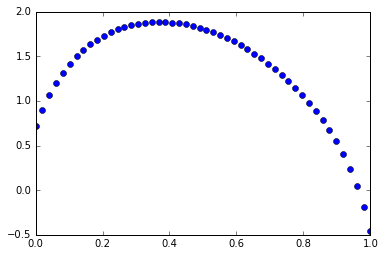

In [93]:
dataframe = prometheus_df[['Subject', 'round', 'taskchosen', 'clueindex', 'columnIndex', 'eventIndex']]
# this is which subject we care about
subject = 12;
# K is the number of basis coefficients in the representation of the Q-function for continue
K = 25;
# M is number of coefficients for uncertainty basis
M = 9;
D = 2;
returnVal = findMLestimateBernstein(subject,dataframe,K,M)

#findMLestimateNew(subject,dataframe,K)
thetastar = returnVal[0].value
betastar = thetastar[range(M),0]
alphastar = thetastar[range(M,M+D),0]
loglikelihoodstar = returnVal[1]
#print('thetastar='+ str(thetastar))
print('betastar=' + str(betastar))
print('alphastar=' + str(alphastar))
#thetastar.shape
resolution=50;
maxOrder = M-1
plot_bernstein(maxOrder,resolution,betastar)



maximum second derivative: [          nan -107.05769326  -85.10432391  -67.29240191  -52.994348
  -41.65412853  -32.78174851  -25.94796564  -20.77922553  -16.95281787
  -14.19225377  -12.26286414  -10.96761914  -10.14316875   -9.65610431
   -9.39944127   -9.28932294   -9.26194528   -9.2707029    -9.28355594
   -9.28061824   -9.2519664    -9.19567004   -9.11604307   -9.02211606
   -8.92632969   -8.84344927   -8.78970031   -8.78212521   -8.83816099
   -8.97543815   -9.21180049   -9.56554615  -10.05588963  -10.70364492
  -11.53212967  -12.56829052  -13.84404938  -15.39787091  -17.276551
  -19.53722634  -22.2496051   -25.49841859  -29.38609416  -34.03564899
  -39.5938051   -46.23432536  -54.16157059  -63.61427774           nan]


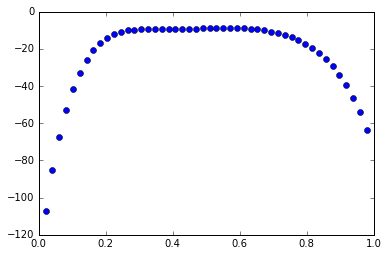

In [94]:
plot_bernstein_secondDeriv(maxOrder,resolution,betastar)

In [78]:
for k in range(1,5):
    print(k)

1
2
3
4


<IPython.core.display.Javascript object>


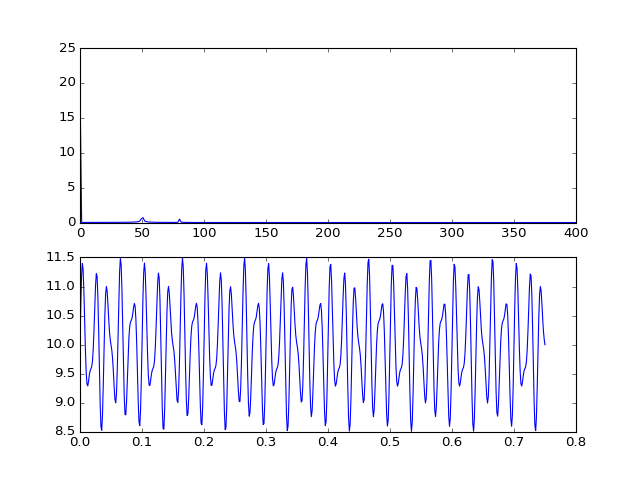

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
%matplotlib notebook
# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = 10 + np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

plt.subplot(2, 1, 1)
plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
plt.subplot(2, 1, 2)
# plt.plot(xf[1:], 2.0/N * np.abs(yf[0:N/2])[1:])
plt.plot(x, y)